<a href="https://colab.research.google.com/github/Sjinjutha/DADS7202-DL/blob/main/DADS7202_HW1_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP**

In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b7d12f35-0e1a-0dd6-de9e-d1c87532656e)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

## if we have pandas, need to convert data to be numpy
import numpy as np 
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow : tensorflow certainly make sure to see GPUs (tensorflow will run on GPUs)
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.8.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from math import floor
import statistics
from sklearn.metrics import make_scorer, accuracy_score

from imblearn.under_sampling import InstanceHardnessThreshold

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, Input
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

#!pip install scikeras
#from scikeras.wrappers import KerasRegressor, KerasClassifier 
#warnings.filterwarnings('ignore')
#pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv("/content/sample_data/data_travel_insurance.csv")
df['Age'] = df['Age'].astype('int')
df = pd.get_dummies(df)

In [ ]:
# Re-scale 
col_rescale = ['Duration', 'Net Sales', 'Commision (in value)',  'Age']
rob_scale = RobustScaler() #StandardScaler() 

for i in col_rescale :
    for j in  df.columns :
        if i == j :
            # RobustScaler is less prone to outliers.
            df[i+'_rescaled'] = rob_scale.fit_transform(df[i].values.reshape(-1,1))

In [ ]:
drop_col = ["Unnamed: 0"] + col_rescale

# Drop and adjust columns
df.drop(drop_col, axis=1, inplace=True)

for i in df.columns[-4:] :
    mv = df.pop(i)
    df.insert(len(df.columns[-4:]), i, mv, allow_duplicates=False)

df.insert(0, "Claim", df.pop("Claim"))

df3 = df

df

,Claim,Agency Type,Distribution Channel,Des_Singapore,Age_rescaled,Commision (in value)_rescaled,Net Sales_rescaled,Duration_rescaled,Product Name_1 way Comprehensive Plan,Product Name_2 way Comprehensive Plan,Product Name_24 Protect,Product Name_Annual Gold Plan,Product Name_Annual Silver Plan,Product Name_Annual Travel Protect Gold,Product Name_Annual Travel Protect Platinum,Product Name_Annual Travel Protect Silver,Product Name_Basic Plan,Product Name_Bronze Plan,Product Name_Cancellation Plan,Product Name_Child Comprehensive Plan,Product Name_Comprehensive Plan,Product Name_Gold Plan,Product Name_Individual Comprehensive Plan,Product Name_Premier Plan,Product Name_Rental Vehicle Excess Insurance,Product Name_Silver Plan,Product Name_Single Trip Travel Protect Gold,Product Name_Single Trip Travel Protect Platinum,Product Name_Single Trip Travel Protect Silver,Product Name_Spouse or Parents Comprehensive Plan,Product Name_Ticket Protector,Product Name_Travel Cruise Protect,Product Name_Travel Cruise Protect Family,Product Name_Value Plan,Destination_ALBANIA,Destination_ANGOLA,Destination_ARGENTINA,Destination_ARMENIA,Destination_AUSTRALIA,Destination_AUSTRIA,Destination_AZERBAIJAN,Destination_BAHRAIN,Destination_BANGLADESH,Destination_BARBADOS,Destination_BELARUS,Destination_BELGIUM,Destination_BENIN,Destination_BERMUDA,Destination_BHUTAN,Destination_BOLIVIA,Destination_BOSNIA AND HERZEGOVINA,Destination_BOTSWANA,Destination_BRAZIL,Destination_BRUNEI DARUSSALAM,Destination_BULGARIA,Destination_CAMBODIA,Destination_CAMEROON,Destination_CANADA,Destination_CAYMAN ISLANDS,Destination_CHILE,Destination_CHINA,Destination_COLOMBIA,Destination_COSTA RICA,Destination_CROATIA,Destination_CYPRUS,Destination_CZECH REPUBLIC,Destination_DENMARK,Destination_DOMINICAN REPUBLIC,Destination_ECUADOR,Destination_EGYPT,Destination_ESTONIA,Destination_ETHIOPIA,Destination_FAROE ISLANDS,Destination_FIJI,Destination_FINLAND,Destination_FRANCE,Destination_FRENCH POLYNESIA,Destination_GEORGIA,Destination_GERMANY,Destination_GHANA,Destination_GREECE,Destination_GUADELOUPE,Destination_GUAM,Destination_GUATEMALA,Destination_GUINEA,Destination_GUINEA-BISSAU,Destination_GUYANA,Destination_HONG KONG,Destination_HUNGARY,Destination_ICELAND,Destination_INDIA,Destination_INDONESIA,"Destination_IRAN, ISLAMIC REPUBLIC OF",Destination_IRELAND,Destination_ISRAEL,Destination_ITALY,Destination_JAMAICA,Destination_JAPAN,Destination_JORDAN,Destination_KAZAKHSTAN,Destination_KENYA,"Destination_KOREA, REPUBLIC OF",Destination_KUWAIT,Destination_KYRGYZSTAN,Destination_LAO PEOPLE'S DEMOCRATIC REPUBLIC,Destination_LATVIA,Destination_LEBANON,Destination_LIBYAN ARAB JAMAHIRIYA,Destination_LITHUANIA,Destination_LUXEMBOURG,Destination_MACAO,"Destination_MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF",Destination_MALAYSIA,Destination_MALDIVES,Destination_MALI,Destination_MALTA,Destination_MAURITIUS,Destination_MEXICO,"Destination_MOLDOVA, REPUBLIC OF",Destination_MONGOLIA,Destination_MOROCCO,Destination_MYANMAR,Destination_NAMIBIA,Destination_NEPAL,Destination_NETHERLANDS,Destination_NEW CALEDONIA,Destination_NEW ZEALAND,Destination_NIGERIA,Destination_NORTHERN MARIANA ISLANDS,Destination_NORWAY,Destination_OMAN,Destination_PAKISTAN,Destination_PANAMA,Destination_PAPUA NEW GUINEA,Destination_PERU,Destination_PHILIPPINES,Destination_POLAND,Destination_PORTUGAL,Destination_PUERTO RICO,Destination_QATAR,Destination_REPUBLIC OF MONTENEGRO,Destination_REUNION,Destination_ROMANIA,Destination_RUSSIAN FEDERATION,Destination_RWANDA,Destination_SAMOA,Destination_SAUDI ARABIA,Destination_SENEGAL,Destination_SERBIA,Destination_SEYCHELLES,Destination_SIERRA LEONE,Destination_SINGAPORE,Destination_SLOVENIA,Destination_SOLOMON ISLANDS,Destination_SOUTH AFRICA,Destination_SPAIN,Destination_SRI LANKA,Destination_SWEDEN,Destination_SWITZERLAND,"Destination_TAIWAN, PROVINCE OF CHINA",Destination_TAJIKISTAN,"Destination_TANZANIA, UNITED REPUBLIC OF",Destination_THAILAND,Destination_TRINIDAD AND TOBAG

##**Dealing with inbalance-datasets**
### Method: Random Under-Sampling

In [ ]:
# Splitting the Data (Original DataFrame)

df1 = df

not_claim = 100 * df1.Claim.value_counts()[0] / len(df)
claim_ =    100 * df1.Claim.value_counts()[1] / len(df)
print(f"The one who got 'NOT claim' : {round(not_claim, 2)} % of the dataset.")
print(f"The one who got 'claim'     : {round(claim_, 2)} % of the dataset.")
print(f"Old ratio (test:train) : {round((claim_ / not_claim), 2)}\n")

# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

X_1 = df1.drop('Claim', axis=1)
y_1 = df1['Claim']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X_1, y_1):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X_1.iloc[train_index], X_1.iloc[test_index]
    original_ytrain, original_ytest = y_1.iloc[train_index], y_1.iloc[test_index]
    
print(f"\nNew ratio (test:train) : {round(len(original_Xtest) / len(original_Xtrain), 2)}")

The one who got 'NOT claim' : 98.53 % of the dataset.
The one who got 'claim'     : 1.47 % of the dataset.
Old ratio (test:train) : 0.01

Train: [12372 12373 12374 ... 62339 62340 62341] Test: [    0     1     2 ... 22718 22771 22801]
Train: [    0     1     2 ... 62339 62340 62341] Test: [12372 12373 12374 ... 33847 33908 33913]
Train: [    0     1     2 ... 62339 62340 62341] Test: [24777 24778 24779 ... 43376 43378 43400]
Train: [    0     1     2 ... 62339 62340 62341] Test: [37284 37285 37286 ... 52948 52990 53145]
Train: [    0     1     2 ... 52948 52990 53145] Test: [49808 49809 49810 ... 62339 62340 62341]

New ratio (test:train) : 0.25


In [ ]:
# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)
print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.98528291 0.01471709]
[0.98532243 0.01467757]


In [ ]:
# Random Under-Sampling : which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting
# assuming we want a 80/20 ratio but select all y (in term of 30% of total)

ratio_want = int((100 / 30) * df.Claim.value_counts()[1]) - int(df.Claim.value_counts()[1])

## shuffle dataset
df_1 = df1.sample(frac=1)

claim_df = df_1.loc[df["Claim"] == 1]
not_claim_df = df_1.loc[df["Claim"] == 0][ : ratio_want]

normal_distributed_df = pd.concat([claim_df, not_claim_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df

,Claim,Agency Type,Distribution Channel,Des_Singapore,Age_rescaled,Commision (in value)_rescaled,Net Sales_rescaled,Duration_rescaled,Product Name_1 way Comprehensive Plan,Product Name_2 way Comprehensive Plan,Product Name_24 Protect,Product Name_Annual Gold Plan,Product Name_Annual Silver Plan,Product Name_Annual Travel Protect Gold,Product Name_Annual Travel Protect Platinum,Product Name_Annual Travel Protect Silver,Product Name_Basic Plan,Product Name_Bronze Plan,Product Name_Cancellation Plan,Product Name_Child Comprehensive Plan,Product Name_Comprehensive Plan,Product Name_Gold Plan,Product Name_Individual Comprehensive Plan,Product Name_Premier Plan,Product Name_Rental Vehicle Excess Insurance,Product Name_Silver Plan,Product Name_Single Trip Travel Protect Gold,Product Name_Single Trip Travel Protect Platinum,Product Name_Single Trip Travel Protect Silver,Product Name_Spouse or Parents Comprehensive Plan,Product Name_Ticket Protector,Product Name_Travel Cruise Protect,Product Name_Travel Cruise Protect Family,Product Name_Value Plan,Destination_ALBANIA,Destination_ANGOLA,Destination_ARGENTINA,Destination_ARMENIA,Destination_AUSTRALIA,Destination_AUSTRIA,Destination_AZERBAIJAN,Destination_BAHRAIN,Destination_BANGLADESH,Destination_BARBADOS,Destination_BELARUS,Destination_BELGIUM,Destination_BENIN,Destination_BERMUDA,Destination_BHUTAN,Destination_BOLIVIA,Destination_BOSNIA AND HERZEGOVINA,Destination_BOTSWANA,Destination_BRAZIL,Destination_BRUNEI DARUSSALAM,Destination_BULGARIA,Destination_CAMBODIA,Destination_CAMEROON,Destination_CANADA,Destination_CAYMAN ISLANDS,Destination_CHILE,Destination_CHINA,Destination_COLOMBIA,Destination_COSTA RICA,Destination_CROATIA,Destination_CYPRUS,Destination_CZECH REPUBLIC,Destination_DENMARK,Destination_DOMINICAN REPUBLIC,Destination_ECUADOR,Destination_EGYPT,Destination_ESTONIA,Destination_ETHIOPIA,Destination_FAROE ISLANDS,Destination_FIJI,Destination_FINLAND,Destination_FRANCE,Destination_FRENCH POLYNESIA,Destination_GEORGIA,Destination_GERMANY,Destination_GHANA,Destination_GREECE,Destination_GUADELOUPE,Destination_GUAM,Destination_GUATEMALA,Destination_GUINEA,Destination_GUINEA-BISSAU,Destination_GUYANA,Destination_HONG KONG,Destination_HUNGARY,Destination_ICELAND,Destination_INDIA,Destination_INDONESIA,"Destination_IRAN, ISLAMIC REPUBLIC OF",Destination_IRELAND,Destination_ISRAEL,Destination_ITALY,Destination_JAMAICA,Destination_JAPAN,Destination_JORDAN,Destination_KAZAKHSTAN,Destination_KENYA,"Destination_KOREA, REPUBLIC OF",Destination_KUWAIT,Destination_KYRGYZSTAN,Destination_LAO PEOPLE'S DEMOCRATIC REPUBLIC,Destination_LATVIA,Destination_LEBANON,Destination_LIBYAN ARAB JAMAHIRIYA,Destination_LITHUANIA,Destination_LUXEMBOURG,Destination_MACAO,"Destination_MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF",Destination_MALAYSIA,Destination_MALDIVES,Destination_MALI,Destination_MALTA,Destination_MAURITIUS,Destination_MEXICO,"Destination_MOLDOVA, REPUBLIC OF",Destination_MONGOLIA,Destination_MOROCCO,Destination_MYANMAR,Destination_NAMIBIA,Destination_NEPAL,Destination_NETHERLANDS,Destination_NEW CALEDONIA,Destination_NEW ZEALAND,Destination_NIGERIA,Destination_NORTHERN MARIANA ISLANDS,Destination_NORWAY,Destination_OMAN,Destination_PAKISTAN,Destination_PANAMA,Destination_PAPUA NEW GUINEA,Destination_PERU,Destination_PHILIPPINES,Destination_POLAND,Destination_PORTUGAL,Destination_PUERTO RICO,Destination_QATAR,Destination_REPUBLIC OF MONTENEGRO,Destination_REUNION,Destination_ROMANIA,Destination_RUSSIAN FEDERATION,Destination_RWANDA,Destination_SAMOA,Destination_SAUDI ARABIA,Destination_SENEGAL,Destination_SERBIA,Destination_SEYCHELLES,Destination_SIERRA LEONE,Destination_SINGAPORE,Destination_SLOVENIA,Destination_SOLOMON ISLANDS,Destination_SOUTH AFRICA,Destination_SPAIN,Destination_SRI LANKA,Destination_SWEDEN,Destination_SWITZERLAND,"Destination_TAIWAN, PROVINCE OF CHINA",Destination_TAJIKISTAN,"Destination_TANZANIA, UNITED REPUBLIC OF",Destination_THAILAND,Destination_TRINIDAD AND TOBAG

Distribution of 'Claim' in the subsample dataset
0    0.7
1    0.3
Name: Claim, dtype: float64


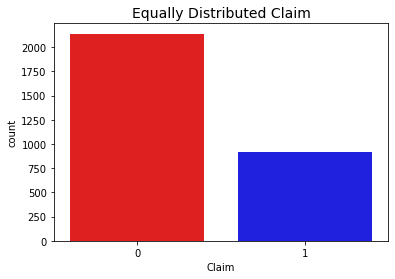

In [ ]:
print("Distribution of 'Claim' in the subsample dataset")
print(round(new_df['Claim'].value_counts()/len(new_df),2))

colors = ['red', 'blue']
sns.countplot('Claim', data=new_df, palette=colors)
plt.title('Equally Distributed Claim', fontsize=14)
plt.show()

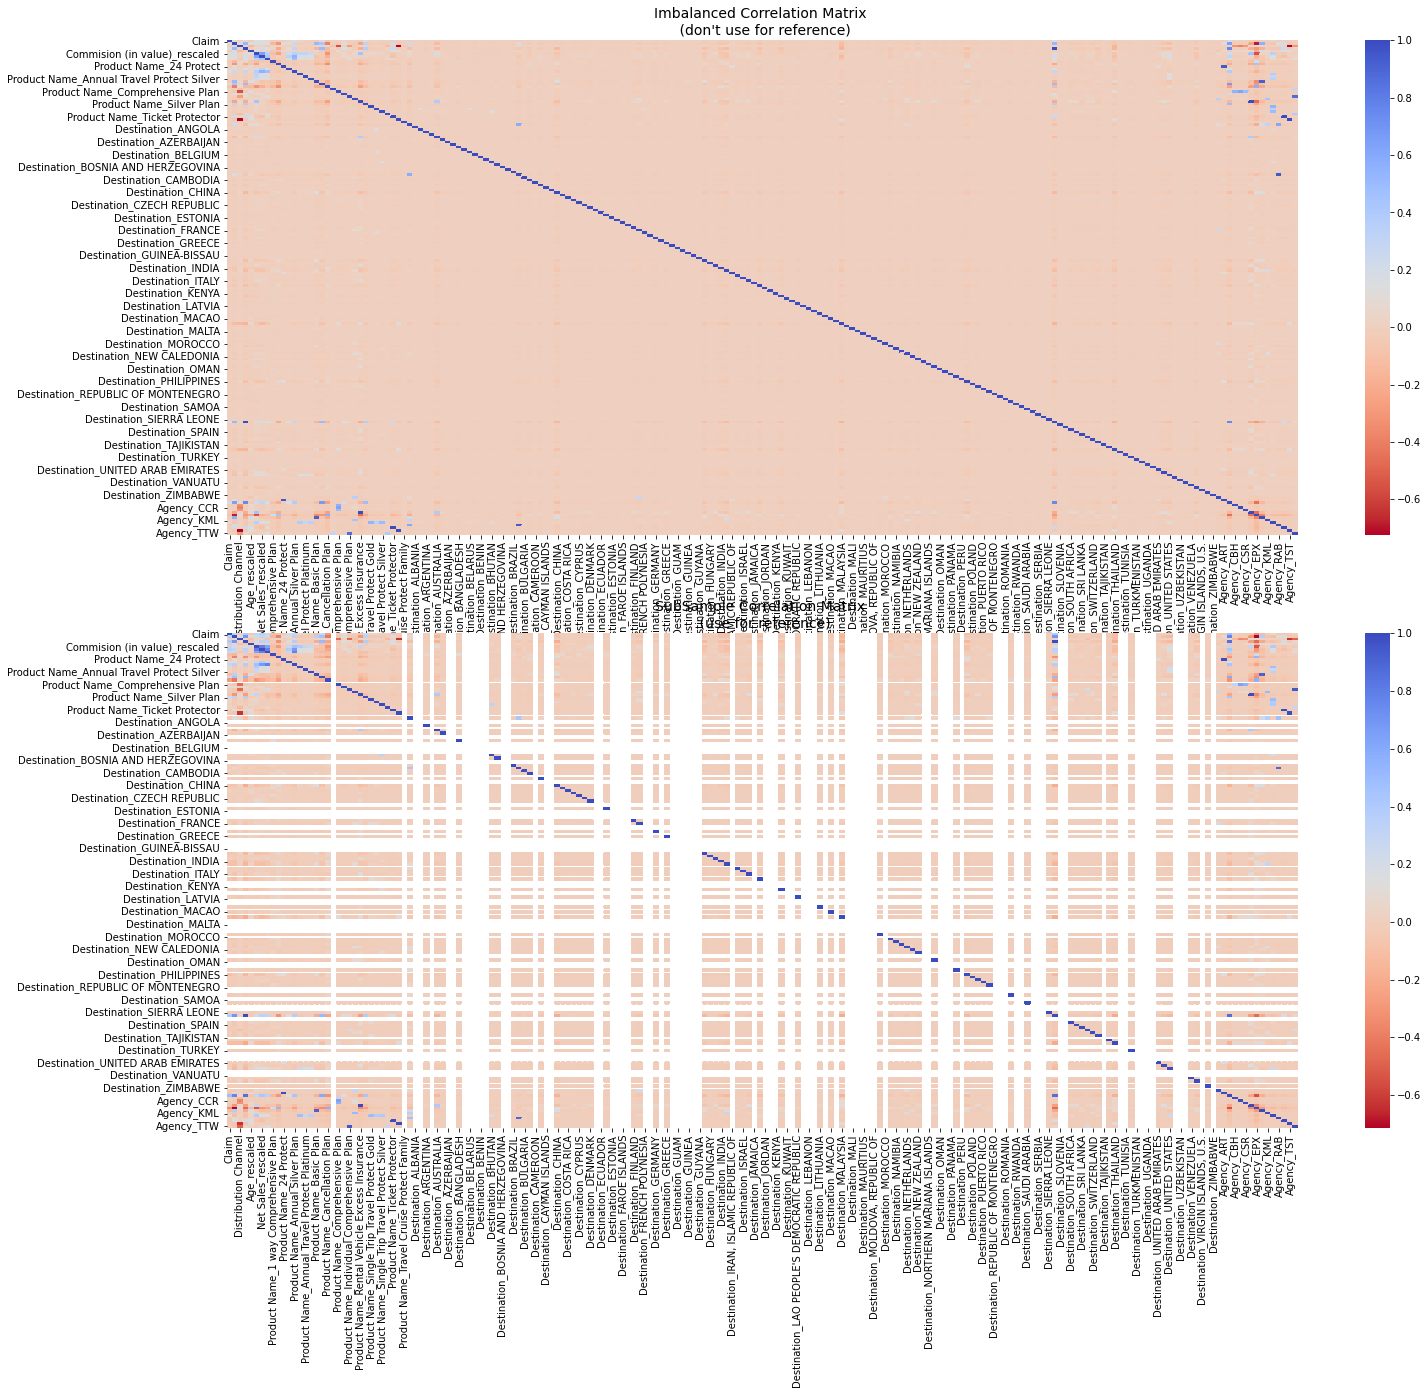

In [ ]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df1.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [ ]:
# Eliminate columns which got higher corr > 0.8

list_drop = []

for index,col in list(zip(corr.unstack().index.to_list(), corr.unstack().to_list())) :
    if (index[0] != index[1]) and (col > abs(0.80)):
        print(index, col)
        
        if (index[1] not in list_drop) and (index[0] not in list_drop) :
            list_drop.append(index[1])

list_drop

('Des_Singapore', 'Destination_SINGAPORE') 1.0
('Product Name_24 Protect', 'Agency_ART') 0.9488644008269954
('Product Name_Basic Plan', 'Agency_JZI') 0.9233318528860562
('Product Name_Individual Comprehensive Plan', 'Agency_TTW') 0.8687985965078227
('Product Name_Rental Vehicle Excess Insurance', 'Agency_CWT') 1.0
('Product Name_Ticket Protector', 'Agency_SSI') 1.0
('Product Name_Travel Cruise Protect', 'Agency_TST') 0.9990445004811632
('Destination_BRUNEI DARUSSALAM', 'Agency_RAB') 0.9440915555472436
('Destination_SINGAPORE', 'Des_Singapore') 1.0
('Agency_ART', 'Product Name_24 Protect') 0.9488644008269954
('Agency_CWT', 'Product Name_Rental Vehicle Excess Insurance') 1.0
('Agency_JZI', 'Product Name_Basic Plan') 0.9233318528860562
('Agency_RAB', 'Destination_BRUNEI DARUSSALAM') 0.9440915555472436
('Agency_SSI', 'Product Name_Ticket Protector') 1.0
('Agency_TST', 'Product Name_Travel Cruise Protect') 0.9990445004811632
('Agency_TTW', 'Product Name_Individual Comprehensive Plan') 0.868

['Destination_SINGAPORE',
 'Agency_ART',
 'Agency_JZI',
 'Agency_TTW',
 'Agency_CWT',
 'Agency_SSI',
 'Agency_TST',
 'Agency_RAB']

In [ ]:
## drop columns already
new_df.drop(list_drop, axis=1, inplace=True)
new_df

,Claim,Agency Type,Distribution Channel,Des_Singapore,Age_rescaled,Commision (in value)_rescaled,Net Sales_rescaled,Duration_rescaled,Product Name_1 way Comprehensive Plan,Product Name_2 way Comprehensive Plan,Product Name_24 Protect,Product Name_Annual Gold Plan,Product Name_Annual Silver Plan,Product Name_Annual Travel Protect Gold,Product Name_Annual Travel Protect Platinum,Product Name_Annual Travel Protect Silver,Product Name_Basic Plan,Product Name_Bronze Plan,Product Name_Cancellation Plan,Product Name_Child Comprehensive Plan,Product Name_Comprehensive Plan,Product Name_Gold Plan,Product Name_Individual Comprehensive Plan,Product Name_Premier Plan,Product Name_Rental Vehicle Excess Insurance,Product Name_Silver Plan,Product Name_Single Trip Travel Protect Gold,Product Name_Single Trip Travel Protect Platinum,Product Name_Single Trip Travel Protect Silver,Product Name_Spouse or Parents Comprehensive Plan,Product Name_Ticket Protector,Product Name_Travel Cruise Protect,Product Name_Travel Cruise Protect Family,Product Name_Value Plan,Destination_ALBANIA,Destination_ANGOLA,Destination_ARGENTINA,Destination_ARMENIA,Destination_AUSTRALIA,Destination_AUSTRIA,Destination_AZERBAIJAN,Destination_BAHRAIN,Destination_BANGLADESH,Destination_BARBADOS,Destination_BELARUS,Destination_BELGIUM,Destination_BENIN,Destination_BERMUDA,Destination_BHUTAN,Destination_BOLIVIA,Destination_BOSNIA AND HERZEGOVINA,Destination_BOTSWANA,Destination_BRAZIL,Destination_BRUNEI DARUSSALAM,Destination_BULGARIA,Destination_CAMBODIA,Destination_CAMEROON,Destination_CANADA,Destination_CAYMAN ISLANDS,Destination_CHILE,Destination_CHINA,Destination_COLOMBIA,Destination_COSTA RICA,Destination_CROATIA,Destination_CYPRUS,Destination_CZECH REPUBLIC,Destination_DENMARK,Destination_DOMINICAN REPUBLIC,Destination_ECUADOR,Destination_EGYPT,Destination_ESTONIA,Destination_ETHIOPIA,Destination_FAROE ISLANDS,Destination_FIJI,Destination_FINLAND,Destination_FRANCE,Destination_FRENCH POLYNESIA,Destination_GEORGIA,Destination_GERMANY,Destination_GHANA,Destination_GREECE,Destination_GUADELOUPE,Destination_GUAM,Destination_GUATEMALA,Destination_GUINEA,Destination_GUINEA-BISSAU,Destination_GUYANA,Destination_HONG KONG,Destination_HUNGARY,Destination_ICELAND,Destination_INDIA,Destination_INDONESIA,"Destination_IRAN, ISLAMIC REPUBLIC OF",Destination_IRELAND,Destination_ISRAEL,Destination_ITALY,Destination_JAMAICA,Destination_JAPAN,Destination_JORDAN,Destination_KAZAKHSTAN,Destination_KENYA,"Destination_KOREA, REPUBLIC OF",Destination_KUWAIT,Destination_KYRGYZSTAN,Destination_LAO PEOPLE'S DEMOCRATIC REPUBLIC,Destination_LATVIA,Destination_LEBANON,Destination_LIBYAN ARAB JAMAHIRIYA,Destination_LITHUANIA,Destination_LUXEMBOURG,Destination_MACAO,"Destination_MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF",Destination_MALAYSIA,Destination_MALDIVES,Destination_MALI,Destination_MALTA,Destination_MAURITIUS,Destination_MEXICO,"Destination_MOLDOVA, REPUBLIC OF",Destination_MONGOLIA,Destination_MOROCCO,Destination_MYANMAR,Destination_NAMIBIA,Destination_NEPAL,Destination_NETHERLANDS,Destination_NEW CALEDONIA,Destination_NEW ZEALAND,Destination_NIGERIA,Destination_NORTHERN MARIANA ISLANDS,Destination_NORWAY,Destination_OMAN,Destination_PAKISTAN,Destination_PANAMA,Destination_PAPUA NEW GUINEA,Destination_PERU,Destination_PHILIPPINES,Destination_POLAND,Destination_PORTUGAL,Destination_PUERTO RICO,Destination_QATAR,Destination_REPUBLIC OF MONTENEGRO,Destination_REUNION,Destination_ROMANIA,Destination_RUSSIAN FEDERATION,Destination_RWANDA,Destination_SAMOA,Destination_SAUDI ARABIA,Destination_SENEGAL,Destination_SERBIA,Destination_SEYCHELLES,Destination_SIERRA LEONE,Destination_SLOVENIA,Destination_SOLOMON ISLANDS,Destination_SOUTH AFRICA,Destination_SPAIN,Destination_SRI LANKA,Destination_SWEDEN,Destination_SWITZERLAND,"Destination_TAIWAN, PROVINCE OF CHINA",Destination_TAJIKISTAN,"Destination_TANZANIA, UNITED REPUBLIC OF",Destination_THAILAND,Destination_TRINIDAD AND TOBAGO,Destination_TUNISIA,

In [ ]:
X_new_1 = new_df.iloc[:, 1:].values # .values
y_new_1 = new_df.iloc[:, 0].values

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_new_1, y_new_1, test_size=0.3, random_state=42)

In [ ]:
# Check shape and type

print( f"X_train.shape={X_train_1.shape} , X_train.dtype={X_train_1.dtype} , min(X_train)={np.min(X_train_1)} , max(X_train)={np.max(X_train_1)}" )
print( f"y_train.shape={y_train_1.shape} , y_train.dtype={y_train_1.dtype} , min(y_train)={np.min(y_train_1)} , max(y_train)={np.max(y_train_1)}" )
print()
print( f"X_test.shape={X_test_1.shape} , X_test.dtype={X_test_1.dtype} , min(X_test)={np.min(X_test_1)} , max(X_test)={np.max(X_test_1)}" )
print( f"y_test.shape={y_test_1.shape} , y_test.dtype={y_test_1.dtype} , min(y_test)={np.min(y_test_1)} , max(y_test)={np.max(y_test_1)}" )

X_train.shape=(2139, 187) , X_train.dtype=float64 , min(X_train)=-4.826666666666667 , max(X_train)=20.02
y_train.shape=(2139,) , y_train.dtype=int64 , min(y_train)=0 , max(y_train)=1

X_test.shape=(917, 187) , X_test.dtype=float64 , min(X_test)=-3.6666666666666665 , max(X_test)=15.86
y_test.shape=(917,) , y_test.dtype=int64 , min(y_test)=0 , max(y_test)=1


In [ ]:
# Data format: data type : need to be a correct/certain data type
# Most DL frameworks use float32 as a default data type

X_train_1 = X_train_1.astype(np.float32)
X_test_1 = X_test_1.astype(np.float32)

print( f"X_train.shape={X_train_1.shape} , X_train.dtype={X_train_1.dtype} , min(X_train)={np.min(X_train_1)} , max(X_train)={np.max(X_train_1)}" )
print( f"X_test.shape={X_test_1.shape} , X_test.dtype={X_test_1.dtype} , min(X_test)={np.min(X_test_1)} , max(X_test)={np.max(X_test_1)}" )

X_train.shape=(2139, 187) , X_train.dtype=float32 , min(X_train)=-4.826666831970215 , max(X_train)=20.020000457763672
X_test.shape=(917, 187) , X_test.dtype=float32 , min(X_test)=-3.6666667461395264 , max(X_test)=15.859999656677246


In [ ]:
input_dim_num = X_train_1.shape[1] # the number of features per one input
output_dim = 1     # the number of output classes - 1
EPOCHS = 500
BATCH_SIZE = 128
patience_me = 32
learning_rate = 0.5
decay_rate = 5e-6

# Sequential model
model = tf.keras.models.Sequential()

# Input layer
model.add(Input(shape=(input_dim_num,)))
# Hidden layer
model.add(Dense(32, activation='softplus', name='hidden1'))
model.add(BatchNormalization(axis=-1, name='bn1'))
model.add(Dense(64, activation='softplus', name='hidden2'))
model.add(BatchNormalization(axis=-1, name='bn2'))
model.add(Dense(32, activation='softplus', name='hidden3'))
model.add(Dropout(0.3)) # drop rate = 30%
# Output layer
model.add(Dense(output_dim, activation='softplus', name='output'))

# Compile with default values for both optimizer and loss
sgd = SGD(learning_rate=learning_rate, decay=decay_rate)
adam = Adam(learning_rate=learning_rate)

model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc']) # sparse_categorical_crossentropy

## OR 
# model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , 
               # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) , metrics=['acc'] )

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 32)                6016      
                                                                 
 bn1 (BatchNormalization)    (None, 32)                128       
                                                                 
 hidden2 (Dense)             (None, 64)                2112      
                                                                 
 bn2 (BatchNormalization)    (None, 64)                256       
                                                                 
 hidden3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 output (Dense)              (None, 1)               

In [ ]:
# check model.weights
# model.weights

In [ ]:
checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)
es_1 = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=patience_me, restore_best_weights=True)
model_hist_1 = model.fit(X_train_1, y_train_1, batch_size=128, epochs=EPOCHS, verbose=1, 
                      validation_split=0.3, callbacks=[es_1])

Epoch 1/500
12/12 [==============================] - 1s 20ms/step - loss: 2.9195 - acc: 0.6433 - val_loss: 0.9788 - val_acc: 0.7072
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 0.9958 - acc: 0.7301 - val_loss: 1.2518 - val_acc: 0.2928
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 0.7903 - acc: 0.7301 - val_loss: 0.5815 - val_acc: 0.7477
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 0.5208 - acc: 0.7615 - val_loss: 0.6463 - val_acc: 0.7072
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 0.5305 - acc: 0.7615 - val_loss: 0.5299 - val_acc: 0.7305
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 0.4999 - acc: 0.7562 - val_loss: 0.5932 - val_acc: 0.7960
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 0.5010 - acc: 0.7762 - val_loss: 0.5599 - val_acc: 0.7804
Epoch 8/500
12/12 [==============================] - 0s 7ms/step - loss: 0.4850 - 

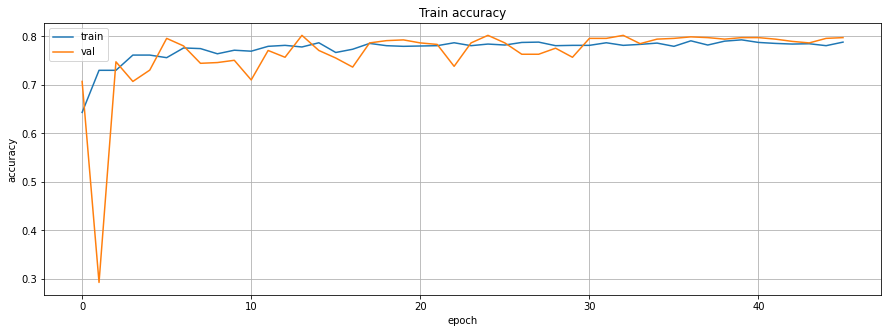

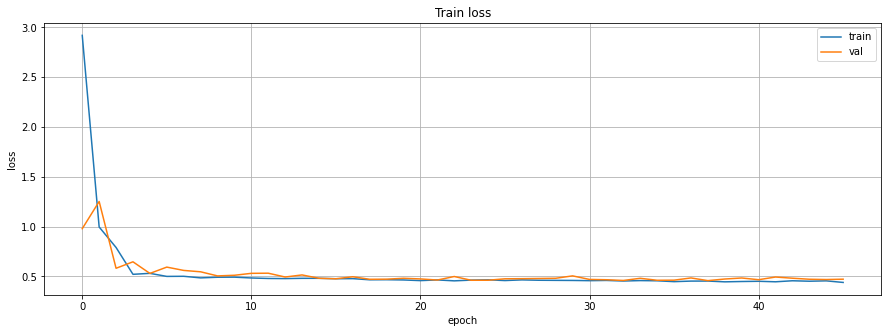

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(model_hist_1.history['acc'])
plt.plot(model_hist_1.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(model_hist_1.history['loss'])
plt.plot(model_hist_1.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
y_pred_1 = model.predict(X_test_1, batch_size=256, verbose=1, callbacks=[es_1] )
results_1 = model.evaluate(X_test_1, y_test_1)
print( f"{model.metrics_names} = {results_1}" )

29/29 [==============================] - 0s 2ms/step - loss: 0.5165 - acc: 0.8059
['loss', 'acc'] = [0.5164549946784973, 0.8058887720108032]


## Test 5 rounds

In [ ]:
# Iteration round 1, 2, 3, 4, 5

number_seed = [1234, 123, 12, 42, 1]
accuracy_list = []

def round_five_iter(number_seed, verbose_see=1) :
    np.random.seed(i)
    tf.random.set_seed(i)
    print(f"This is a round {i+1}")

    model_hist_1 = model.fit(X_train_1, y_train_1, batch_size=128, epochs=EPOCHS, verbose=1, 
                        validation_split=0.3, callbacks=[es_1])
    
    y_pred_1 = model.predict(X_test_1, batch_size=256, verbose=verbose_see, callbacks=[es_1] )
    results_1 = model.evaluate(X_test_1, y_test_1)
    print( f"round {i+1}: {model.metrics_names} = {results_1}" )

    accuracy_list.append(results_1[1])

    # Summarize history for accuracy
    plt.figure(figsize=(15,5))
    plt.plot(model_hist_1.history['acc'])
    plt.plot(model_hist_1.history['val_acc'])
    plt.title('Train accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

    # Summarize history for loss
    plt.figure(figsize=(15,5))
    plt.plot(model_hist_1.history['loss'])
    plt.plot(model_hist_1.history['val_loss'])
    plt.title('Train loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()

    print(f"{'-'*100}")

This is a round 5
Epoch 1/500
12/12 [==============================] - 0s 15ms/step - loss: 0.3812 - acc: 0.8210 - val_loss: 0.7052 - val_acc: 0.7695
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3666 - acc: 0.8170 - val_loss: 0.6366 - val_acc: 0.7648
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3655 - acc: 0.8277 - val_loss: 0.6549 - val_acc: 0.7835
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3869 - acc: 0.8136 - val_loss: 0.6249 - val_acc: 0.7850
Epoch 5/500
12/12 [==============================] - 0s 6ms/step - loss: 0.3859 - acc: 0.8176 - val_loss: 0.6314 - val_acc: 0.7850
Epoch 6/500
12/12 [==============================] - 0s 8ms/step - loss: 0.3907 - acc: 0.8183 - val_loss: 0.6516 - val_acc: 0.7741
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 0.3833 - acc: 0.8083 - val_loss: 0.6349 - val_acc: 0.7835
Epoch 8/500
12/12 [==============================] - 0s 6ms/step

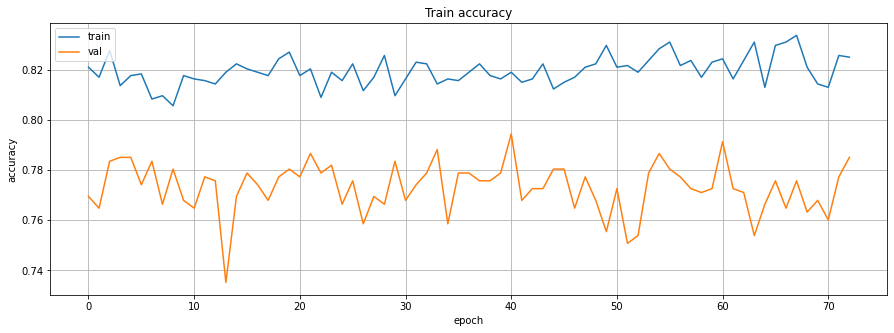

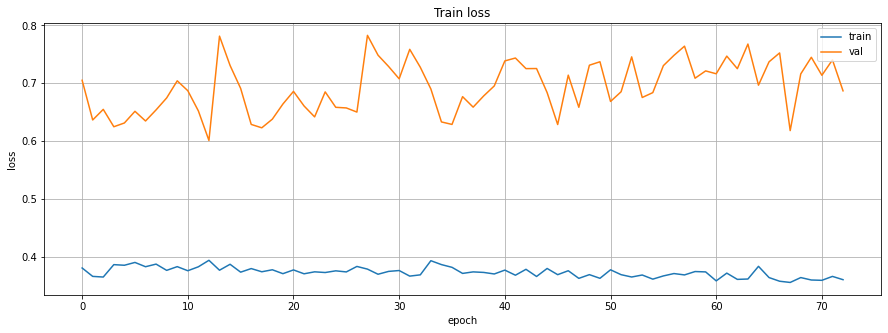

----------------------------------------------------------------------------------------------------


In [ ]:
## Round 1
round_five_iter(1234,1)

This is a round 5
Epoch 1/500
12/12 [==============================] - 0s 13ms/step - loss: 0.3666 - acc: 0.8190 - val_loss: 0.7795 - val_acc: 0.7477
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3583 - acc: 0.8210 - val_loss: 0.6957 - val_acc: 0.7757
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3562 - acc: 0.8277 - val_loss: 0.7505 - val_acc: 0.7710
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3717 - acc: 0.8143 - val_loss: 0.6924 - val_acc: 0.7804
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3655 - acc: 0.8290 - val_loss: 0.7249 - val_acc: 0.7835
Epoch 6/500
12/12 [==============================] - 0s 8ms/step - loss: 0.3752 - acc: 0.8303 - val_loss: 0.7433 - val_acc: 0.7523
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3684 - acc: 0.8176 - val_loss: 0.6917 - val_acc: 0.7850
Epoch 8/500
12/12 [==============================] - 0s 7ms/step

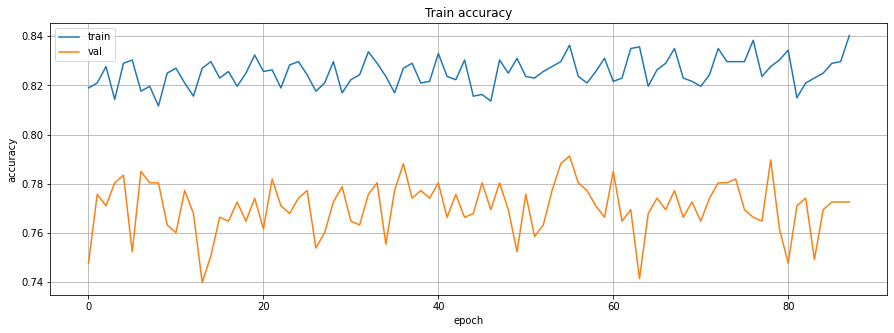

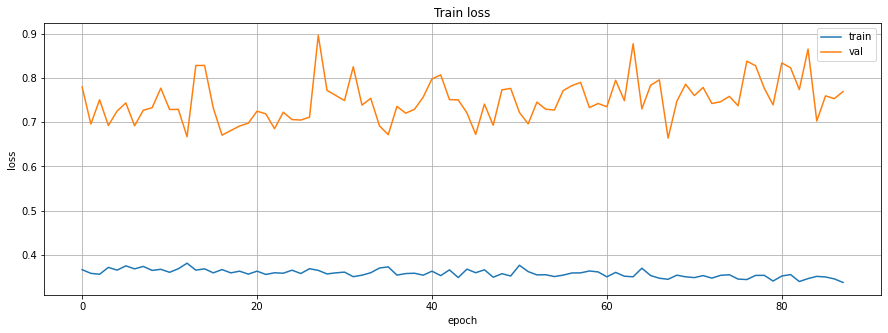

----------------------------------------------------------------------------------------------------


In [ ]:
## Round 2
round_five_iter(123, 1)

This is a round 5
Epoch 1/500
12/12 [==============================] - 0s 13ms/step - loss: 0.3461 - acc: 0.8337 - val_loss: 0.8714 - val_acc: 0.7539
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3435 - acc: 0.8330 - val_loss: 0.7315 - val_acc: 0.7804
Epoch 3/500
12/12 [==============================] - 0s 6ms/step - loss: 0.3448 - acc: 0.8303 - val_loss: 0.7328 - val_acc: 0.7710
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3514 - acc: 0.8236 - val_loss: 0.7518 - val_acc: 0.7757
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3453 - acc: 0.8383 - val_loss: 0.8066 - val_acc: 0.7866
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3576 - acc: 0.8330 - val_loss: 0.8208 - val_acc: 0.7492
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3511 - acc: 0.8223 - val_loss: 0.7304 - val_acc: 0.7850
Epoch 8/500
12/12 [==============================] - 0s 6ms/step

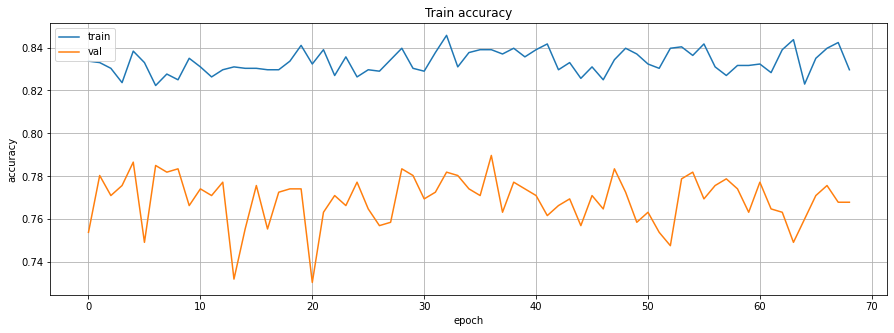

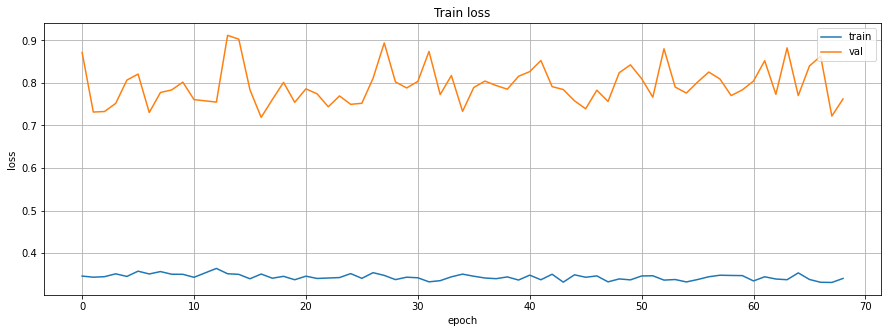

----------------------------------------------------------------------------------------------------


In [ ]:
## Round 3
round_five_iter(12, 0)

This is a round 5
Epoch 1/500
12/12 [==============================] - 0s 13ms/step - loss: 0.3389 - acc: 0.8403 - val_loss: 0.8787 - val_acc: 0.7430
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3357 - acc: 0.8350 - val_loss: 0.7772 - val_acc: 0.7695
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 0.3361 - acc: 0.8377 - val_loss: 0.7576 - val_acc: 0.7741
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 0.3415 - acc: 0.8357 - val_loss: 0.8235 - val_acc: 0.7710
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 0.3338 - acc: 0.8410 - val_loss: 0.8498 - val_acc: 0.7835
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3475 - acc: 0.8370 - val_loss: 0.8461 - val_acc: 0.7570
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 0.3381 - acc: 0.8337 - val_loss: 0.7499 - val_acc: 0.7819
Epoch 8/500
12/12 [==============================] - 0s 9ms/step

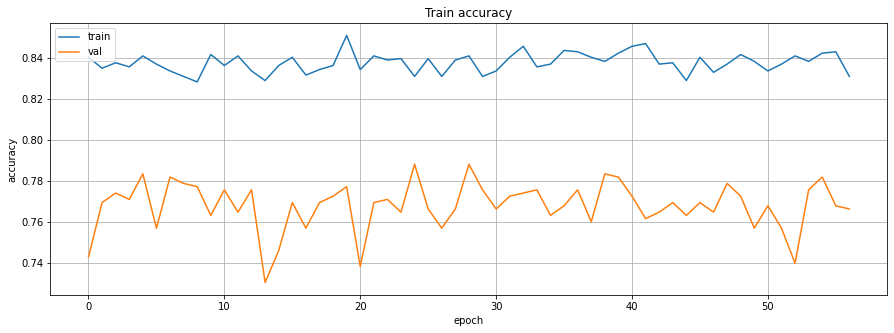

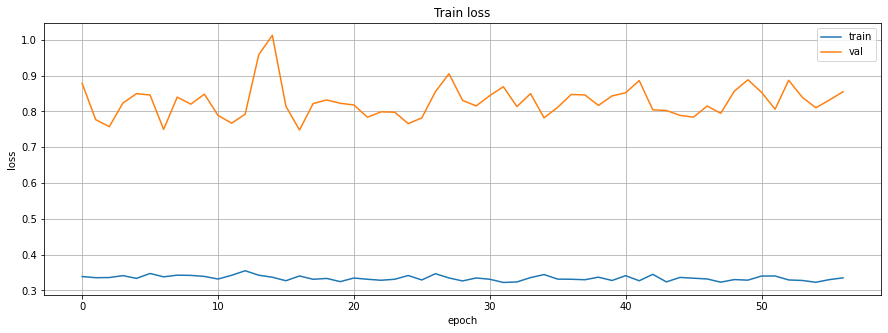

----------------------------------------------------------------------------------------------------


In [ ]:
## Round 4
round_five_iter(42, 0)

This is a round 5
Epoch 1/500
12/12 [==============================] - 0s 13ms/step - loss: 0.3284 - acc: 0.8410 - val_loss: 0.9023 - val_acc: 0.7601
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 0.3255 - acc: 0.8363 - val_loss: 0.7906 - val_acc: 0.7632
Epoch 3/500
12/12 [==============================] - 0s 6ms/step - loss: 0.3291 - acc: 0.8403 - val_loss: 0.7795 - val_acc: 0.7695
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3355 - acc: 0.8437 - val_loss: 0.9012 - val_acc: 0.7461
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3361 - acc: 0.8370 - val_loss: 0.8434 - val_acc: 0.7773
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 0.3402 - acc: 0.8363 - val_loss: 0.8159 - val_acc: 0.7741
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3302 - acc: 0.8397 - val_loss: 0.7594 - val_acc: 0.7819
Epoch 8/500
12/12 [==============================] - 0s 7ms/step

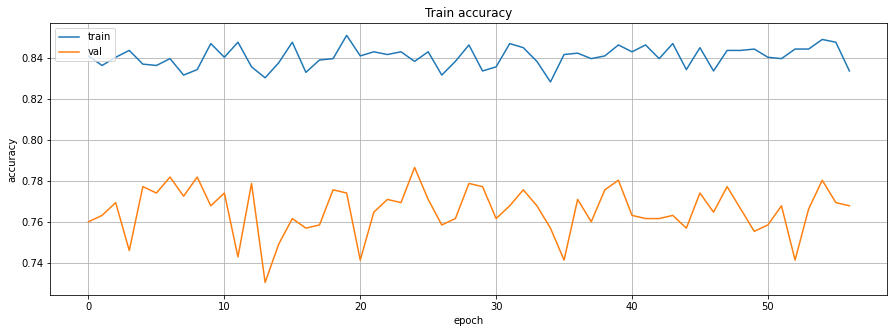

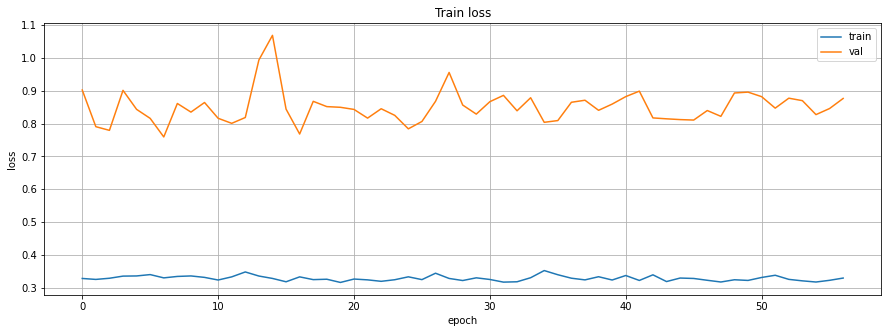

----------------------------------------------------------------------------------------------------


In [ ]:
## Round 5
round_five_iter(1, 0)

This is a round 5
Epoch 1/500
12/12 [==============================] - 0s 13ms/step - loss: 0.3206 - acc: 0.8424 - val_loss: 0.9109 - val_acc: 0.7617
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3186 - acc: 0.8410 - val_loss: 0.8110 - val_acc: 0.7601
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3237 - acc: 0.8444 - val_loss: 0.8005 - val_acc: 0.7726
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 0.3343 - acc: 0.8510 - val_loss: 0.8663 - val_acc: 0.7679
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3178 - acc: 0.8424 - val_loss: 0.9137 - val_acc: 0.7570
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3367 - acc: 0.8343 - val_loss: 0.8289 - val_acc: 0.7664
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 0.3222 - acc: 0.8417 - val_loss: 0.7852 - val_acc: 0.7710
Epoch 8/500
12/12 [==============================] - 0s 7ms/step

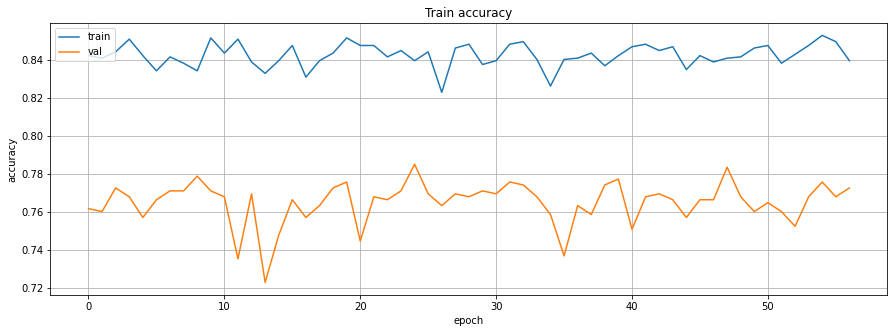

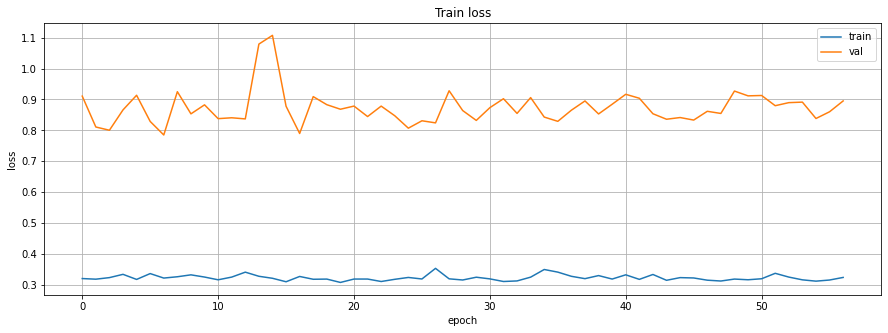

----------------------------------------------------------------------------------------------------
29/29 [==============================] - 0s 2ms/step - loss: 0.7048 - acc: 0.7612
['loss', 'acc'] = [0.7047832012176514, 0.7611777782440186]


In [ ]:
# We use Round 2 to evaluate model

## Round 2
round_five_iter(123, 1)

#y_pred_1 = model.predict(X_test_1, batch_size=256, verbose=1, callbacks=[es_1] )
results_1 = model.evaluate(X_test_1, y_test_1)
print( f"{model.metrics_names} = {results_1}" )

In [ ]:
# measure accuracy_list

print(f"accuracy_list: {accuracy_list}")

mean_acc = statistics.mean(accuracy_list)
SD_acc = statistics.stdev(accuracy_list)
 
print("Mean is :", mean_acc)
print("SD is :", SD_acc)

accuracy_list: [0.7731733918190002, 0.7862595319747925, 0.7786259651184082, 0.7666302919387817, 0.7666302919387817]
Mean is : 0.7742638945579529
SD is : 0.008376394670876747
